In [1]:
# Import libraries
import pandas as pd
import numpy as np
eps = np.finfo(float).eps  #smallest possible number (to prevent division by 0 in information gain calculation)

In [2]:
# Notebook options
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Decision tree

Decision trees can easily be used for both regression and classification problems. <br>
The great advantage of the decision tree is the easy interpretation and graphical representation of the structure.

It works by starting at a root node and splitting the data based on the feature that results in the highest information gain. <br>
For regression this is the largest decrease in Residual Sum of Squares (RSS), for classification this is the largest decrease in entropy. <br>
After each split the data is divided and the next decision boundary is set. <br>
This process is repeated until a stopping criterion is met (max levels/depth reached, min samples left to split, nothing left to split, etc.). <br>
The goal is to result in groups with the same characteristics either belonging to the same class or having samilar values without overfitting the data.

After the model is fitted, the result is a flow chart like structure. This structure can be used with applied if-else conditions (e.g. if male go right if female go left), in order to predict the outcome for new unseen data. Any test observation will follow the flow schema and fall in a specific region (leaf). For the regression tree, the prediction is the mean of training values in that leaf, for classification we take the mode of that leaf.

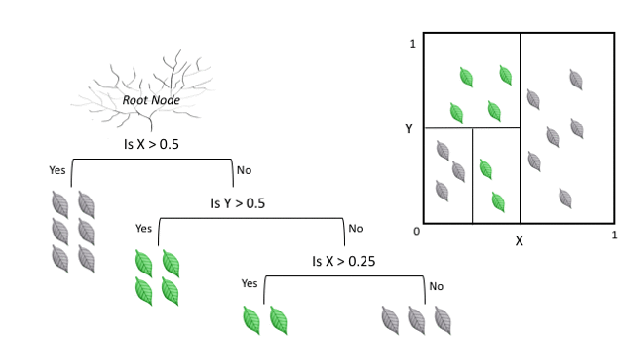

For regression problems, we use the RSS. If we have only one split, the RSS will be the sum of the squared difference between the actuals in group 1 and the mean in group 1, plus the sum of the squared difference between the actuals in group 2 and the mean in group 2.
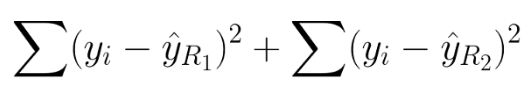

For classification problems, we first calculate the entropy score at the root by using the following formula:
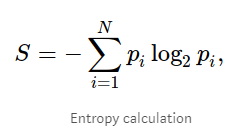

Followed by calculating the information gain of each split, choosing the split that minimizes the entropy score.
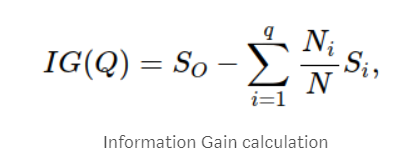

If we have only two classes, the entropy is maximum if in a leaf there are an equal number of objects from different attributes (like the group has 50 cats and 50 dogs), and this is minimum if the node is pure (like the group has only 100 cats or only 100 dogs). We ultimately want to have minimum entropy for the tree, i.e. pure or uniform classes at the leaf nodes.

Why use the log2 in the calculation? Because it scales nicely to one and is additive. <br>
For instance, the entropy of a fair coin toss is 1 bit. A bit being a binary integer, meaning either 1 or 0 with equal probability in the case of the fair coin. 1 bit being the highest level of uncertainty; there is no possible way of predicting whether the coin toss is going to result in head or tails. <br>

In [4]:
# The logarithm with base 2 of 0.5 = -1, meaning that 0.5 to the power of -1 will result in 2.
np.log2(0.5)

-1.0

In [5]:
# Multiplying the log2(p) with p itself ensures the possibilities to add the values together while staying in range -1 to 0.
0.5*np.log2(0.5)

-0.5

In [6]:
# Adding these probabilities together and muliplying with -1 to get in range 0 to 1, 
# will result in an easy interpretable entropy score
-np.sum([0.5*np.log2(0.5), 0.5*np.log2(0.5)])

1.0

In contrast, a coin toss using a coin that has two heads and no tails has zero entropy since the coin will always come up heads, and the outcome can be predicted perfectly. A unfair coin with probabilty of 0.75 to turn up heads and 0.25 to turn up tails, is more easy to predict compared to the fair coin and more difficult to predict compared to the coin with only heads.

In [7]:
-np.sum([0.75*np.log2(0.75), 0.25*np.log2(0.25)])

0.8112781244591328

Using this entropy calculation, we see indeed that a very high or very low probability of a class in a leaf (low uncertainty) results in a low entropy and a probability closer to average results in a higher entropy (high uncertainty).

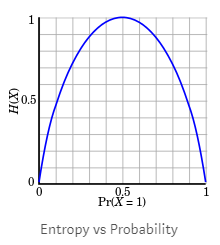

What we want, is to gain as much information as possible in each step so that the (average) entropy in the next nodes is a low as possible. Since the entropy scores can be added, what we do is multiply each entropy in the next layer of nodes with each size, i.e. observations, in respect to the total size of the dataset. <br>
This way, the split that seperates the target as well as possible is rewarded the most, but the reward is weighed by the number of observations in the node in order to create a model that fits best on all data rather than just a very small subset.

Let's see how it works with a dataset. The following dataset has three categorical predictor variables; preferences in taste, temperature and texture, which together can determine whether someone would eat a dish (yes/no).

In [8]:
# Initiate dataset
dataset = {'Taste': ['Salty','Spicy','Spicy','Spicy','Spicy','Sweet','Salty','Sweet','Spicy','Salty'],
           'Temperature': ['Hot','Hot','Hot','Cold','Hot','Cold','Cold','Hot','Cold','Hot'],
           'Texture': ['Soft','Soft','Hard','Hard','Hard','Soft','Soft','Soft','Soft','Hard'],
           'Eat': ['No','No','Yes','No','Yes','Yes','No','Yes','Yes','Yes']}

df = pd.DataFrame(dataset, columns = ['Taste','Temperature','Texture','Eat'])

In [9]:
df

,Taste,Temperature,Texture,Eat
0,Salty,Hot,Soft,No
1,Spicy,Hot,Soft,No
2,Spicy,Hot,Hard,Yes
3,Spicy,Cold,Hard,No
4,Spicy,Hot,Hard,Yes
5,Sweet,Cold,Soft,Yes
6,Salty,Cold,Soft,No
7,Sweet,Hot,Soft,Yes
8,Spicy,Cold,Soft,Yes
9,Salty,Hot,Hard,Yes


Inside the entropy calculation we first need the probabilities of each class. This is simply the percentage of times the class occurs in the whole dataset. 

In [10]:
proba_yes = df[df['Eat'] == 'Yes'].shape[0] / df.shape[0]
proba_no = df[df['Eat'] == 'No'].shape[0] / df.shape[0]
print("The probability to randomly select a 'Yes' in the target column is: {}".format(proba_yes))
print("The probability to randomly select a 'No' in the target column is: {}".format(proba_no))

The probability to randomly select a 'Yes' in the target column is: 0.6
The probability to randomly select a 'No' in the target column is: 0.4


In [11]:
# Start with calculating the initial entropy at the root
S = -np.sum([proba_yes*np.log2(proba_yes), proba_no*np.log2(proba_no)])
print("The entropy score at the root is: {}. Close to one, therefore almost as high as possible.".format(round(S, 3)))

The entropy score at the root is: 0.971. Close to one, therefore almost as high as possible.


Since we only have three variables and they all have only two/three possible answers, there are just three splits possible. This makes it easy to calculate the split that results in the highest information gain.

In [12]:
# Information gain for taste:
proba_salty = df[df['Taste'] == 'Salty'].shape[0] / df.shape[0]
proba_spicy = df[df['Taste'] == 'Spicy'].shape[0] / df.shape[0]
proba_sweet = df[df['Taste'] == 'Sweet'].shape[0] / df.shape[0]

proba_salty_yes = df[(df['Taste'] == 'Salty') & (df['Eat'] == 'Yes')].shape[0] / df[df['Taste'] == 'Salty'].shape[0]
proba_salty_no = df[(df['Taste'] == 'Salty') & (df['Eat'] == 'No')].shape[0] / df[df['Taste'] == 'Salty'].shape[0]

proba_spicy_yes = df[(df['Taste'] == 'Spicy') & (df['Eat'] == 'Yes')].shape[0] / df[df['Taste'] == 'Spicy'].shape[0]
proba_spicy_no = df[(df['Taste'] == 'Spicy') & (df['Eat'] == 'No')].shape[0] / df[df['Taste'] == 'Spicy'].shape[0]

proba_sweet_yes = df[(df['Taste'] == 'Sweet') & (df['Eat'] == 'Yes')].shape[0] / df[df['Taste'] == 'Sweet'].shape[0]
proba_sweet_no = df[(df['Taste'] == 'Sweet') & (df['Eat'] == 'No')].shape[0] / df[df['Taste'] == 'Sweet'].shape[0]

S_salty = -np.sum([proba_salty_yes*np.log2(proba_salty_yes), proba_salty_no*np.log2(proba_salty_no)])
S_spicy = -np.sum([proba_spicy_yes*np.log2(proba_spicy_yes), proba_spicy_no*np.log2(proba_spicy_no)])
S_sweet = -np.sum([proba_sweet_yes*np.log2(proba_sweet_yes)]) #0 [sweet, No]

E_salty = proba_salty*S_salty
E_spicy = proba_spicy*S_spicy
E_sweet = proba_sweet*S_sweet
E_taste = E_salty + E_spicy + E_sweet
print("The information gain for splitting the tree on taste would be: {}".format(round(S - E_taste, 3)))

The information gain for splitting the tree on taste would be: 0.21


In [13]:
# Information gain for temperature:
proba_hot = df[df['Temperature'] == 'Hot'].shape[0] / df.shape[0]
proba_cold = df[df['Temperature'] == 'Cold'].shape[0] / df.shape[0]

proba_hot_yes = df[(df['Temperature'] == 'Hot') & (df['Eat'] == 'Yes')].shape[0] / df[df['Temperature'] == 'Hot'].shape[0]
proba_hot_no = df[(df['Temperature'] == 'Hot') & (df['Eat'] == 'No')].shape[0] / df[df['Temperature'] == 'Hot'].shape[0]

proba_cold_yes = df[(df['Temperature'] == 'Cold') & (df['Eat'] == 'Yes')].shape[0] / df[df['Temperature'] == 'Cold'].shape[0]
proba_cold_no = df[(df['Temperature'] == 'Cold') & (df['Eat'] == 'No')].shape[0] / df[df['Temperature'] == 'Cold'].shape[0]

S_hot = -np.sum([proba_hot_yes*np.log2(proba_hot_yes), proba_hot_no*np.log2(proba_hot_no)])
S_cold = -np.sum([proba_cold_yes*np.log2(proba_cold_yes), proba_cold_no*np.log2(proba_cold_no)])

E_hot = proba_hot*S_hot
E_cold = proba_cold*S_cold
E_temp = E_hot + E_cold
print("The information gain for splitting the tree on temperature would be: {}".format(round(S - E_temp, 3)))

The information gain for splitting the tree on temperature would be: 0.02


In [14]:
# Information gain for texture:
proba_soft = df[df['Texture'] == 'Soft'].shape[0] / df.shape[0]
proba_hard = df[df['Texture'] == 'Hard'].shape[0] / df.shape[0]

proba_soft_yes = df[(df['Texture'] == 'Soft') & (df['Eat'] == 'Yes')].shape[0] / df[df['Texture'] == 'Soft'].shape[0]
proba_soft_no = df[(df['Texture'] == 'Soft') & (df['Eat'] == 'No')].shape[0] / df[df['Texture'] == 'Soft'].shape[0]

proba_hard_yes = df[(df['Texture'] == 'Hard') & (df['Eat'] == 'Yes')].shape[0] / df[df['Texture'] == 'Hard'].shape[0]
proba_hard_no = df[(df['Texture'] == 'Hard') & (df['Eat'] == 'No')].shape[0] / df[df['Texture'] == 'Hard'].shape[0]

S_soft = -np.sum([proba_soft_yes*np.log2(proba_soft_yes), proba_soft_no*np.log2(proba_soft_no)])
S_hard = -np.sum([proba_hard_yes*np.log2(proba_hard_yes), proba_hard_no*np.log2(proba_hard_no)])

E_soft = proba_soft*S_soft
E_hard = proba_hard*S_hard
E_texture = E_soft + E_hard
print("The information gain for splitting the tree on texture would be: {}".format(round(S - E_texture, 3)))

The information gain for splitting the tree on texture would be: 0.046


Looking at the information gains for the categorical features, we see that the first split (the split with the highest information gain) is on taste. We can already see that all the people preferring a sweet taste will eat this product. For the branches spicy and salty, we will need more branches to get pure leafs.
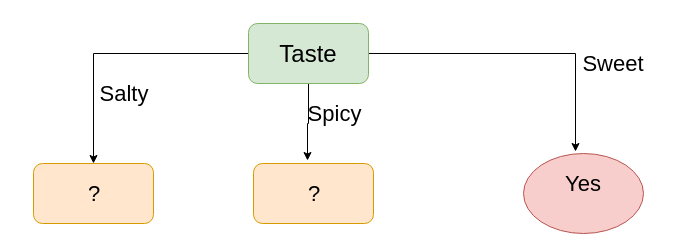

Now we continue to do the same thing for the branches that are not pure yet, i.e. salty and spicy. There are now only two possible splits left; texture and temperature. We start by calculating a new entropy score for the nodes, followed by the information gains of the possible splits.
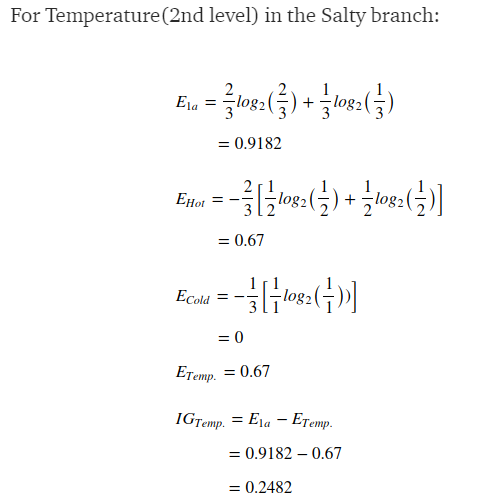

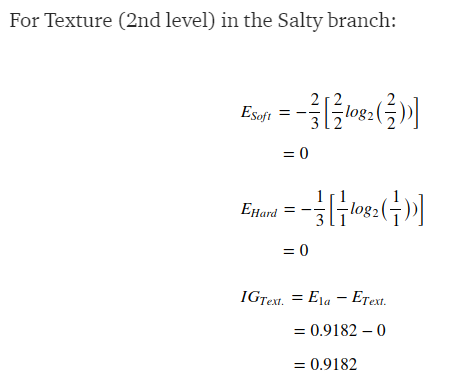

The best split in the salty branch would be texture, which would result in pure leafs. In the spicy branch we need to get a little deeper, resulting in a complete tree looking as follows.
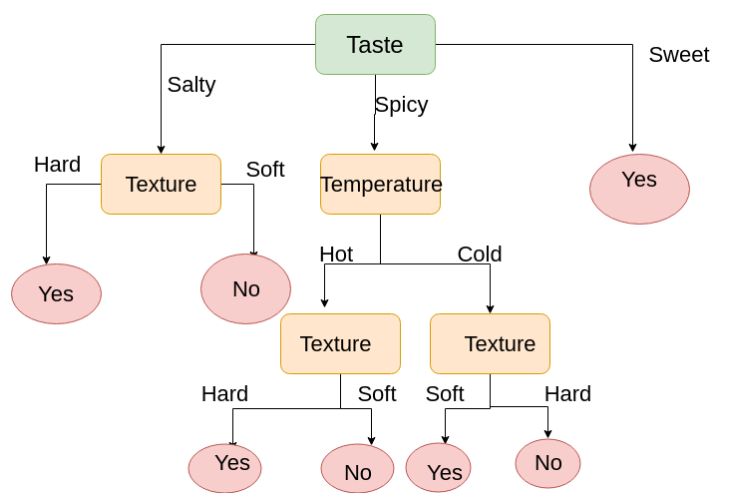

Let's now work this example out more structured, using functions. <br>
Note that the target variable should be in the last column.

In [15]:
# Create function to calculate initial entropy score at the root
def find_entropy(df):
    target = df.keys()[-1]   
    entropy = 0
    values = df[target].unique()
    for value in values:
        fraction = df[target].value_counts()[value]/len(df[target])
        entropy += -fraction*np.log2(fraction)
    return entropy

In [16]:
# Show the entropy score at the root
find_entropy(df)

0.9709505944546686

In [17]:
# Create function to calculate entropy scores per feature
def find_entropy_attribute(df, feature):
    target = df.keys()[-1]  
    target_values = df[target].unique()  
    feature_values = df[feature].unique()
    entropy2 = 0
    for feature_value in feature_values:
        entropy = 0
        for target_value in target_values:
            num = len(df[feature][df[feature] == feature_value][df[target] == target_value])
            den = len(df[feature][df[feature] == feature_value])
            fraction = num/(den+eps)
            entropy += -fraction*np.log2(fraction+eps)
        fraction2 = den/len(df)
        entropy2 += -fraction2*entropy
    return abs(entropy2)

In [18]:
# Show the different levels of Information Gains at the first split
print("The IG when splitting in 'Taste' would be: {}".format(round(find_entropy(df) - find_entropy_attribute(df, 'Taste'), 3)))
print("The IG when splitting in 'Texture' would be: {}".format(round(find_entropy(df) - find_entropy_attribute(df, 'Texture'), 3)))
print("The IG when splitting in 'Temperature' would be: {}".format(round(find_entropy(df) - find_entropy_attribute(df, 'Temperature'), 3)))

The IG when splitting in 'Taste' would be: 0.21
The IG when splitting in 'Texture' would be: 0.046
The IG when splitting in 'Temperature' would be: 0.02


In [19]:
# Create a function that determines a winning split using the find entropy function inside of it
def find_winner(df):
    IG = []
    for key in df.keys()[:-1]:
        IG.append(find_entropy(df)-find_entropy_attribute(df,key))
    return df.keys()[:-1][np.argmax(IG)]

In [20]:
# Show that indeed the best split is on Taste
find_winner(df)

'Taste'

In [21]:
# Create a function that returns the remaining dataframe at a node
def get_subtable(df, node, value):
    return df[df[node] == value].reset_index(drop=True)

In [22]:
# Show the observations that would be left after first splitting on Taste and going in the 'Spicy' branch
get_subtable(df, 'Taste', 'Spicy')

,Taste,Temperature,Texture,Eat
0,Spicy,Hot,Soft,No
1,Spicy,Hot,Hard,Yes
2,Spicy,Cold,Hard,No
3,Spicy,Hot,Hard,Yes
4,Spicy,Cold,Soft,Yes


In [23]:
# Create a function that puts it all together and returns the final decision tree
def buildTree(df, tree=None): 
    target = df.keys()[-1]   

    # Get the attribute with the maximum information gain
    node = find_winner(df)
    
    # Get distinct values of that attribute
    attValue = np.unique(df[node])
    
    # If we started this tree at the root, we create an empty dictionary to initialize the tree    
    if tree is None:                    
        tree={}
        tree[node] = {}
    
    # We make a loop to construct a tree by calling this function recursively. 
    # In this we check if the subset is pure and stops if it is pure. 

    for value in attValue:
        
        subtable = get_subtable(df, node, value)
        clValue, counts = np.unique(subtable['Eat'], return_counts=True)                        
        
        if len(counts)==1: # Checking purity of subset
            tree[node][value] = clValue[0]                                                    
        else:        
            tree[node][value] = buildTree(subtable) # Calling the function recursively 
                   
    return tree

__Some additional information about this function.__ <br>
We continue to split untill all nodes are pure, this function does not include a stopping mechanism for e.g. max depth or min samples left to split. Therefore, when using this function on a larger dataset it is likely to overfit. <br>
Important to understand is that this function is recursive, meaning we start at the root and add branches after each other until each leaf is pure. If the leaf in a branch is not pure yet, the function will be called again (from inside the function) to create another branch at the current node.

In [24]:
# For each value in the winning attribute we will perform the loop..
node = find_winner(df)
attValue = np.unique(df[node])
attValue 

array(['Salty', 'Spicy', 'Sweet'], dtype=object)

In [25]:
# Initializing the tree structure with the winning attribute
tree={}
tree[node] = {}
tree

{'Taste': {}}

In [26]:
# Use 'Salty' as a taste example to show the subtable on which the branch will be based
value = 'Salty'
subtable = get_subtable(df, node, value)
subtable

,Taste,Temperature,Texture,Eat
0,Salty,Hot,Soft,No
1,Salty,Cold,Soft,No
2,Salty,Hot,Hard,Yes


In [27]:
# The length of the counts is > 1, therefore the leaf is not yet pure. Meaning the subtable will be fed into the function again,
# to continue adding branches 
np.unique(subtable['Eat'], return_counts=True)

(array(['No', 'Yes'], dtype=object), array([2, 1], dtype=int64))

In [28]:
# The resulting tree of the Eat-dataset
eat_tree = buildTree(df)
eat_tree

{'Taste': {'Salty': {'Texture': {'Hard': 'Yes', 'Soft': 'No'}},
  'Spicy': {'Temperature': {'Cold': {'Texture': {'Hard': 'No', 'Soft': 'Yes'}},
    'Hot': {'Texture': {'Hard': 'Yes', 'Soft': 'No'}}}},
  'Sweet': 'Yes'}}

As we can see, this corresponds to the immage of the tree we produced earlier. <br>
Now we just need a function that will use this tree to predict a Yes/No value based on the input variables. 

In [29]:
# Predicting function using the tree created before
def predict(inst, tree):

    for nodes in tree.keys():        
        
        value = inst[nodes]
        tree = tree[nodes][value]
        prediction = 0
            
        if type(tree) is dict:
            prediction = predict(inst, tree)
        else:
            prediction = tree
            break;                            
        
    return prediction

What we do is recursively going through the tree that we created earlier. Starting at the root, going through the branches based on the input values, each time returning a smaller sub-part of the tree until we reach a leaf or end point.

In [30]:
# Let's create an example of someone who would prefer their food Salty, Cold and Soft.
new_data = pd.DataFrame({'Taste': ['Salty'], 
                         'Temperature': ['Cold'], 
                         'Texture': ['Soft']})

In [31]:
inst = new_data.iloc[0]
inst

Taste          Salty
Temperature     Cold
Texture         Soft
Name: 0, dtype: object

In [32]:
# Starting at the root we see we must start with Taste
eat_tree.keys()

dict_keys(['Taste'])

In [33]:
# let's pick the value that we input for Taste and show the remaining tree
nodes = 'Taste'

value = inst[nodes]
tree = eat_tree[nodes][value]

value, tree

('Salty', {'Texture': {'Hard': 'Yes', 'Soft': 'No'}})

In [34]:
# We see that the type is still a dictionary so we should continue by using the resulting tree in the function again
type(tree)

dict

In [35]:
# The next split is texture
tree.keys()

dict_keys(['Texture'])

In [36]:
# let's pick the value that we input for Taste and show the remaining tree
nodes = 'Texture'

value = inst[nodes]
tree = tree[nodes][value]

value, tree

('Soft', 'No')

In [37]:
# The resulting tree is now a string and so we have our answer; No
type(tree)

str

In [38]:
# Now that we understand the workings we can have the function do it for us
# For this instance the prediction is 'No'
predict(inst, eat_tree)

'No'

### Check with SKlearn

In [39]:
import pydotplus

from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  

In [40]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files (x86)\Graphviz2.38/bin/'

SKlearn's DecisionTreeClassifier does it a little differently. It requires the data to be integers instead of strings, thus losing the information of categorical features. To prevent this, dummies should be created first. This however results in two-way splits only (unlike our example, where we first split on 3 tastes). It does however make it easier to split on continuous variables (which were not in our example). <br> 
Knowing the difference, let's check with SKlearn whether the results are still the same.

In [42]:
# Encode the variables to integers and create dummies
dummie_cols = df['Taste'].unique()
dummies = pd.get_dummies(df['Taste'])
dummies.columns = dummie_cols

for col in df.columns[1:]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
df = pd.concat([dummies, df.iloc[:,1:]], axis=1)

In [50]:
# As we can see, there are no some different (more specific on Taste) splits possible
df

,Salty,Spicy,Sweet,Temperature,Texture,Eat
0,1,0,0,1,1,0
1,0,1,0,1,1,0
2,0,1,0,1,0,1
3,0,1,0,0,0,0
4,0,1,0,1,0,1
5,0,0,1,0,1,1
6,1,0,0,0,1,0
7,0,0,1,1,1,1
8,0,1,0,0,1,1
9,1,0,0,1,0,1


In [51]:
# We should first split our data in predictors and target variables
X = df[['Salty', 'Spicy', 'Sweet', 'Temperature', 'Texture']]
Y = df[['Eat']]

In [52]:
# Create a decesion tree instance with parameters the same as in our example (clf = classifier)
clf = tree.DecisionTreeClassifier(criterion = 'entropy', 
                                  max_depth = None, 
                                  min_samples_split = 2)

In [53]:
# Build a decision tree classifier from the training set
clf.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [57]:
# In integer terms our Salty, Cold, Soft data is now 0, 0, 1
new_data = pd.DataFrame({'Salty': [1],
                         'Spicy': [0],
                         'Sweet': [0],
                         'Temperature': [0], 
                         'Texture': [1]})

# SKlearn requires an array, we need some reshaping since it is only one sample
inst = np.array(new_data.iloc[0]).reshape(1, -1)
inst

array([[1, 0, 0, 0, 1]], dtype=int64)

Even though the tree is slightly different, the prediction remains the same. 

In [58]:
# And indeed Sklearn also predict 0 meaning 'No'
clf.predict(inst)[0]

0

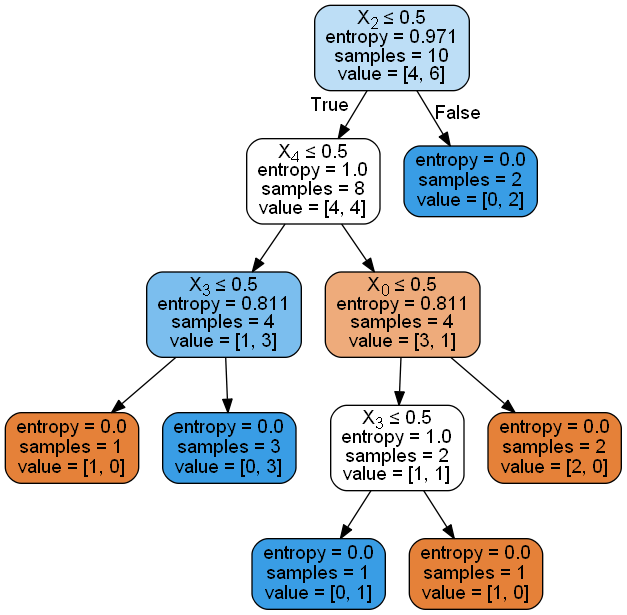

In [59]:
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In [3]:
# Used resources:
#https://medium.com/@rakendd/building-decision-trees-and-its-math-711862eea1c0
#https://medium.com/@rakendd/decision-tree-from-scratch-9e23bcfb4928
#https://en.wikipedia.org/wiki/Entropy_(information_theory)
#https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier